In [126]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools
import spacy
import nltk
%matplotlib inline

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [129]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [131]:
# dataframe display options
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)

# Preparing Dataset

In [16]:
def prepare_data(df):
    y = df.category
    X = df[['title', 'additional_info']].values 
    print("X:", X.shape, " y:", y.shape)
    return X,y

In [17]:
X, y = prepare_data(g)

X: (1089, 2)  y: (1089,)


In [18]:
def join_columns(X):
    X_joined = []
    for x in X:
        X_joined.append(str(x[0]) + str(" - ") + str(x[1]))
    return np.array(X_joined).reshape(-1, 1)

In [19]:
def correct_type(X):
    X_corrected = []
    for x in X:
        if x == np.nan:
            X_corrected.append("None")
        else:
            X_corrected.append(str(x))
    return np.array(X_corrected).reshape(-1, 1)

In [20]:
X_title = correct_type(X[:,0])
X_additional = correct_type(X[:,1])
X_joined = join_columns(X)
print(X_joined.shape, X_title.shape, X_additional.shape)

(1089, 1) (1089, 1) (1089, 1)


In [21]:
X_joined[4][0]

'vihaan 1st birthday party - we would also like the photographer to take candid shots, use flash lighting and would require amazing snaps to keep for memories.'

In [22]:
X_title[4][0]

'vihaan 1st birthday party'

In [23]:
X_additional[4][0]

'we would also like the photographer to take candid shots, use flash lighting and would require amazing snaps to keep for memories.'

### Split dataset into train and test

I have three sets of data:
+ Set 1: combination of title and additional information
+ Set 2: title
+ Set 3: additional information

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_joined, y, test_size=0.3, stratify=y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_title, y, test_size=0.3, stratify=y)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_additional, y, test_size=0.3, stratify=y)

In [25]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(762, 1) (327, 1) (762,) (327,)


# Normalization: Stemming vs Lemmatization 

In [27]:
# Spacy for tokenization and lemmatization
en_nlp = spacy.load('en')

In [28]:
# List of NLTK stemmers to the tested 
snowball = nltk.stem.SnowballStemmer("english")
lancaster = nltk.stem.LancasterStemmer()
porter = nltk.stem.PorterStemmer()

In [29]:
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # Lemmatization
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Porter:")
    print([porter.stem(token.norm_.lower()) for token in doc_spacy])
    print("snowball:")
    print([snowball.stem(token.norm_.lower()) for token in doc_spacy])    
    print("lancaster:")
    print([lancaster.stem(token.norm_.lower()) for token in doc_spacy])    

In [30]:
compare_normalization(u"this is an informal reception at our apartment complex before we have a wedding. we would like to spend the first 1-2 hours on portraits of just the two of us at nice spots around our apartment complex or any other ideas you have. we would like some nice portraits. then capture a bit of the event.")

Lemmatization:
['this', 'be', 'an', 'informal', 'reception', 'at', 'our', 'apartment', 'complex', 'before', 'we', 'have', 'a', 'wedding', '.', 'we', 'would', 'like', 'to', 'spend', 'the', 'first', '1', '-', '2', 'hour', 'on', 'portrait', 'of', 'just', 'the', 'two', 'of', 'us', 'at', 'nice', 'spot', 'around', 'our', 'apartment', 'complex', 'or', 'any', 'other', 'idea', 'you', 'have', '.', 'we', 'would', 'like', 'some', 'nice', 'portrait', '.', 'then', 'capture', 'a', 'bit', 'of', 'the', 'event', '.']
Porter:
['thi', 'is', 'an', 'inform', 'recept', 'at', 'our', 'apart', 'complex', 'befor', 'we', 'have', 'a', 'wed', '.', 'we', 'would', 'like', 'to', 'spend', 'the', 'first', '1', '-', '2', 'hour', 'on', 'portrait', 'of', 'just', 'the', 'two', 'of', 'us', 'at', 'nice', 'spot', 'around', 'our', 'apart', 'complex', 'or', 'ani', 'other', 'idea', 'you', 'have', '.', 'we', 'would', 'like', 'some', 'nice', 'portrait', '.', 'then', 'captur', 'a', 'bit', 'of', 'the', 'event', '.']
snowball:
['this'

In [31]:
compare_normalization(u"i would like to have the photographer take a lot of pics of the president (rakesh kumar) mingling with the guests. also, individualized couples and family pics by the fireplace. i would like photos of decorations, desserts, displays etc. i can give more direction once i meet with the photographer.")

Lemmatization:
['i', 'would', 'like', 'to', 'have', 'the', 'photographer', 'take', 'a', 'lot', 'of', 'pic', 'of', 'the', 'president', '(', 'rakesh', 'kumar', ')', 'mingle', 'with', 'the', 'guest', '.', 'also', ',', 'individualized', 'couple', 'and', 'family', 'pic', 'by', 'the', 'fireplace', '.', 'i', 'would', 'like', 'photo', 'of', 'decoration', ',', 'dessert', ',', 'display', 'etc', '.', 'i', 'can', 'give', 'more', 'direction', 'once', 'i', 'meet', 'with', 'the', 'photographer', '.']
Porter:
['i', 'would', 'like', 'to', 'have', 'the', 'photograph', 'take', 'a', 'lot', 'of', 'pic', 'of', 'the', 'presid', '(', 'rakesh', 'kumar', ')', 'mingl', 'with', 'the', 'guest', '.', 'also', ',', 'individu', 'coupl', 'and', 'famili', 'pic', 'by', 'the', 'fireplac', '.', 'i', 'would', 'like', 'photo', 'of', 'decor', ',', 'dessert', ',', 'display', 'etc', '.', 'i', 'can', 'give', 'more', 'direct', 'onc', 'i', 'meet', 'with', 'the', 'photograph', '.']
snowball:
['i', 'would', 'like', 'to', 'have', 'th

> Lemmatization seem to mantain keywords in context. I will use lemmatization on the vectorizers

In [33]:
import re
regexp = re.compile('(?u)\\b\\w\\w+\\b') # regexp used in CountVectorizer

In [34]:
old_tokenizer = en_nlp.tokenizer
# replacing the tokenizer
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

In [35]:
def custom_tokenizer(document):
    doc_spacy = en_nlp(document, entity=False, parse=False) 
    return [token.lemma_ for token in doc_spacy]

### Stop words

I used the stop words during the cleanup process

In [36]:
from sklearn.feature_extraction import text 

In [37]:
my_additional_stop_words = ["nan", "test", "fdghjkl", "test2", "dddfgb2v", "etc"]

In [38]:
s_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

# Vectorizers

### Count Vectorizer

In [39]:
count_vect = CountVectorizer(analyzer=u'word', tokenizer=custom_tokenizer, stop_words=s_words, ngram_range=(1,2), min_df=3)

In [40]:
X_train_counts = count_vect.fit_transform(X_train.ravel())
X_test_counts = count_vect.transform(X_test.ravel())
print(X_train_counts.shape, X_test_counts.shape, "Vocabulary size: ", len(count_vect.vocabulary_))

(762, 1099) (327, 1099) Vocabulary size:  1099


### Binary Count Vectorizer

In [41]:
count_vect_bin = CountVectorizer(analyzer=u'word', tokenizer=custom_tokenizer, binary=True, stop_words=s_words, ngram_range=(1,2), min_df=3)

In [42]:
X_train_counts_bin = count_vect_bin.fit_transform(X_train.ravel())
X_test_counts_bin = count_vect_bin.transform(X_test.ravel())
print(X_train_counts_bin.shape, X_test_counts_bin.shape, "Vocabulary size: ", len(count_vect_bin.vocabulary_))

(762, 1099) (327, 1099) Vocabulary size:  1099


### Term Frequency Vectorizer

In [43]:
tf = TfidfTransformer(use_idf=False)
X_train_tf = tf.fit_transform(X_train_counts)
X_test_tf = tf.transform(X_test_counts)
print(X_train_tf.shape, X_test_tf.shape)

(762, 1099) (327, 1099)


### Tf-idf Vectorizer

An even more effective way to vectorize text data is by using Tfidf. In brief, you can multiply the term frequency of the words that compose a document by the inverse document frequency of the word itself (that is, in the number of documents it appears, if logarithmically scaled). This is very handy to highlight words that effectively describe each document, and is a powerful discriminative element among the dataset.

In [44]:
tf_idf = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=s_words, ngram_range=(1,2), min_df=3)

In [45]:
X_train_tfidf = tf_idf.fit_transform(X_train.ravel())
X_test_tfidf = tf_idf.transform(X_test.ravel())
print(X_train_tfidf.shape, X_test_tfidf.shape, "Vocabulary size: ", len(tf_idf.vocabulary_))

(762, 1099) (327, 1099) Vocabulary size:  1099


# Very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable.

# Building Baseline model

According to Sklearn documentation:
> Inherently multiclass: Naive Bayes, Decision Trees, Random Forests, Nearest Neighbors,  LogisticRegression ('multinomial')

In [47]:
#Baseline models:
models = []
models.append(('MNB', MultinomialNB()))
models.append(('CART', DecisionTreeClassifier())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('LR', LogisticRegression(multi_class='multinomial', solver='newton-cg'))) 
models.append(('SVM', LinearSVC())) 

In [48]:
# Test options and evaluation metric
num_folds = 5
seed = 7
scoring = 'accuracy'

In [49]:
def compute_baseline(models, X_train_counts, y_train, num_folds, scoring):
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(model, X_train_counts, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print("[{}] \t{:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std()))

    return names, results

In [50]:
def plot_baseline(names, results, classes=9, order=True, guess=True):
    #sorting prior to plotting
    if order == True:
        rm = np.median(results, axis=1)
        idxs = np.argsort(rm)[::-1]
        names = np.array(names)[idxs]
        r = []
        for i in idxs:
            r.append(results[i])
        results = r   
    fig = plt.figure() 
    plt.title('Algorithm Comparison')
    plt.ylabel("Accuracy Score")
    ax = fig.add_subplot(111) 
    plt.boxplot(results)
    if guess:
        plt.ylim(0,1)
        plt.hlines(y=1/classes, xmin=0, xmax =10, linestyles="--", label='Guessing', color='g')
        plt.legend()
    ax.set_xticklabels(names) 
    plt.show()

In [51]:
def evaluate_features(models, X_train_counts, y_train, num_folds, scoring, guess=True):
    names, results = compute_baseline(models, X_train_counts, y_train, num_folds, scoring)
    plot_baseline(names, results, order=True, classes=len(np.unique(y_train)), guess=guess)

## Evaluating models with each of the different types of vectorizers created in the previous section

[MNB] 	0.585 (0.061)
[CART] 	0.566 (0.041)
[KNN] 	0.499 (0.047)
[LR] 	0.630 (0.046)
[SVM] 	0.604 (0.045)


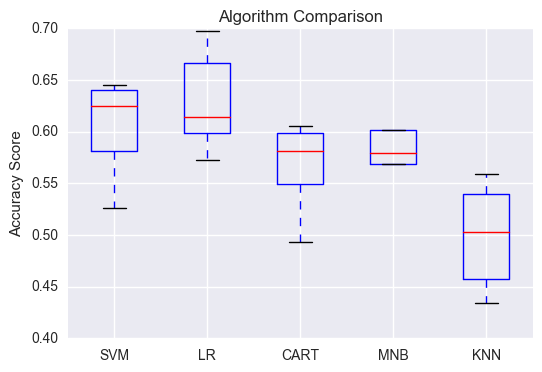

In [134]:
evaluate_features(models, X_train_counts, y_train, num_folds, scoring, guess=False)

> SVM and Logistic Regression do well with a simple count vertorizer

[MNB] 	0.589 (0.062)
[CART] 	0.568 (0.039)
[KNN] 	0.507 (0.041)
[LR] 	0.631 (0.050)
[SVM] 	0.612 (0.045)


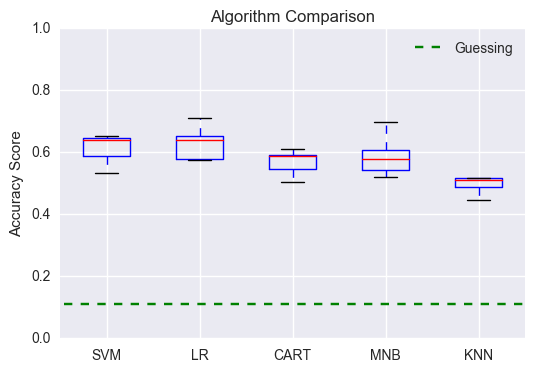

In [135]:
evaluate_features(models, X_train_counts_bin, y_train, num_folds, scoring)

## TermFrequency

[MNB] 	0.500 (0.076)
[CART] 	0.554 (0.026)
[KNN] 	0.404 (0.027)
[LR] 	0.600 (0.071)
[SVM] 	0.631 (0.047)


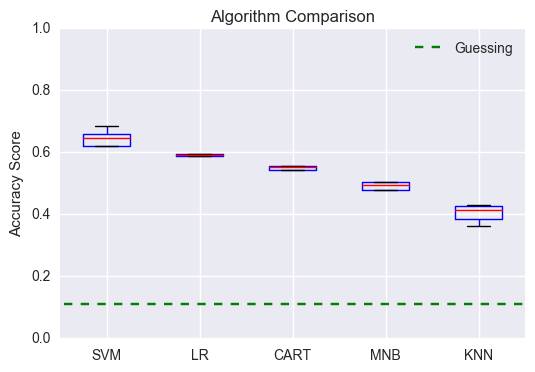

In [136]:
evaluate_features(models, X_train_tf, y_train, num_folds, scoring)

[MNB] 	0.509 (0.075)
[CART] 	0.552 (0.027)
[KNN] 	0.312 (0.040)
[LR] 	0.597 (0.078)
[SVM] 	0.619 (0.036)


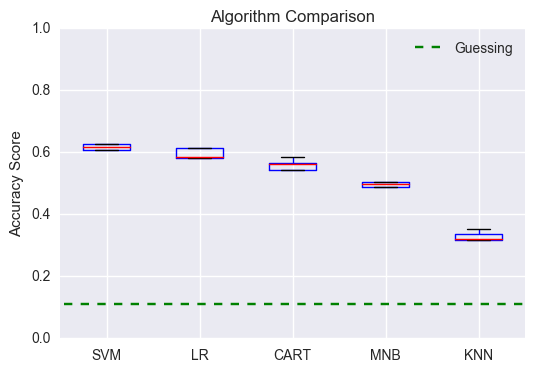

In [55]:
evaluate_features(models, X_train_tfidf, y_train, num_folds, scoring)

> I will proceed to tune the parameters of SVM, LR and MNB

## Emsemble methods

> CART (Decision trees) seem to be performing OK. I am interested in seeing if Random Forest could boost that performance significantly.

In [137]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier())) 
ensembles.append(('RF', RandomForestClassifier())) 

[AB] 	0.490 (0.066)
[RF] 	0.572 (0.054)


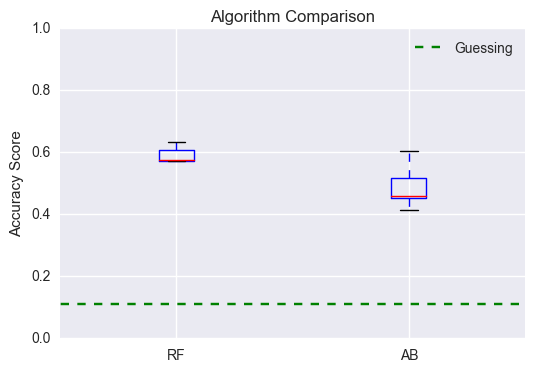

In [138]:
evaluate_features(ensembles, X_train_counts_bin, y_train, num_folds, scoring, guess=True)

[AB] 	0.492 (0.065)
[RF] 	0.571 (0.066)


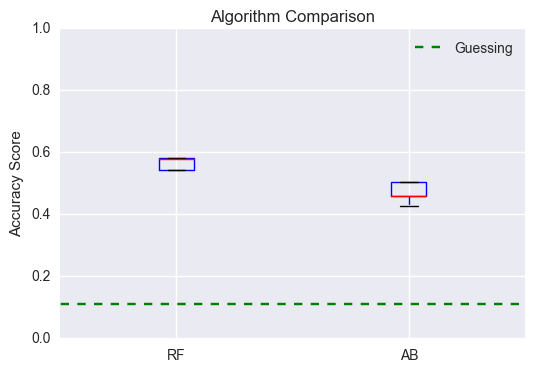

In [139]:
evaluate_features(ensembles, X_train_tf, y_train, num_folds, scoring, guess=True)

[AB] 	0.490 (0.055)
[RF] 	0.570 (0.035)


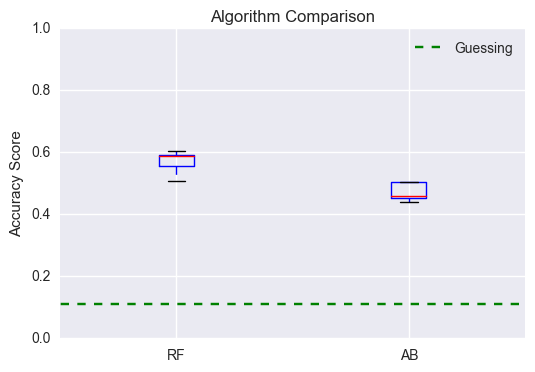

In [140]:
evaluate_features(ensembles, X_train_tfidf, y_train, num_folds, scoring, guess=True)

> The improvement with default parameters is not significant. I will proceed to fine tune the models selected in the previous section.